In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sci

#shape functions(lagrange basis functions) Psi_i on Reference element
def Psi_0(x):
    return 2*(x-1/2)*(x-1)

def Psi_1(x):
    return 4*x*(1-x) 

def Psi_2(x):
    return 2*x*(x-1/2)

def make_partition(N):
    print('N = ', N)

    ''' 
    function to make mesh partition
    input: 
    N: number of elements

    reurns: 
    x: array of nodes: [0,h,2h,...,1] on the elements
    h: stepsize
    '''
    x = np.linspace(0,1,N+1)
    h = x[1]-x[0]

    return x,h 

def map_to_element_k(x_k,h,tau):
    '''
    map from reference element to K_k
    input: 
    - x (vector of xi's)
    - k (element nr k)
    - h (stepsize)
    -tau (element in [0,1])    
    '''
    return x_k + h*tau

def index_mapping(k, alpha):
    '''
    maps from local to global index
    input: 
    - k: element
    - alpha: local index
    '''
    return 2*k + alpha

def elemental_A(h):
    '''
    make the Elemental stiffness matrix A_{K_k}, for a given stepsize h
    input: 
    -h: elementsize
    
    '''
    A = 1/(3*h)*np.array([[7, -8,1], [-8,16,-8],[1,-8,7]])
    return A


def elemental_load_vec(f, h, x_k):
    """
    Computes the elemental load vector b_{K_k} using Simpson's Rule.
    
    Input:
    - f: The source function f(x).
    - h: elementsize
    - x_k: left endpoint of K_k
    
    Returns:
    - b_local: numpy array (3,)
        The computed elemental load vector.
    """
    # Quadrature points and weights for Simpson's Rule
    xi = np.array([0, 0.5, 1])  # Reference element quadrature points
    weights = np.array([1/6, 4/6, 1/6])  # Simpson's rule weights
    
    # Quadratic shape functions at quadrature points
    psi_funcs = [
        Psi_0, Psi_1, Psi_2]
    
    # Compute b_local using quadrature rule
    b_local = np.zeros(3)
    for i in range(3):  # Iterate over shape functions
        for j in range(3):  # Iterate over quadrature points
            x_mapped = map_to_element_k(x_k,h,xi[j])
            b_local[i] += weights[j] * f(x_mapped) * psi_funcs[i](xi[j])
    
    return h * b_local

def extended_matrix(N,elemental_matrix):
    """
    Assembles the extended global matrix A from given elemental matrices .
    
    input:
    - N: number of elements.
    - elemental_matrix: function to build the elemental matrix

    Returns:
    - A_global: numpy array ((2N+1)x(2N+1))
        The assembled global stiffness matrix.
    """
    _, h = make_partition(N)  # Generate mesh and element size
    num_nodes = 2 * N + 1  # Total number of global nodes
    extetnded = sci.lil_matrix((num_nodes, num_nodes))  #initialise sparce lil_matrix for construction
    
    for k in range(N):  # Loop over elements
        local_matrix = elemental_matrix(h)  # Get elemental matrix
        global_indices = [index_mapping(k, alpha) for alpha in range(3)]  # Map local to global

        # Assemble into global matrix
        for i in range(3):
            for j in range(3):
                extetnded[global_indices[i], global_indices[j]] += local_matrix[i, j]
    
    return extetnded.tocsr() #convert to csr for efficient computations


def extended_load_vector(N, f):
    """
    Assembles the extended global load vector b from elemental load vectors.
    
    input:
    - N: Number of elements.
    - f: Source function f(x).

    Returns:
    - b_global: numpy array (2N+1,)
        The assembled global load vector.
    """
    x, h = make_partition(N)  # Generate mesh and element size
    num_nodes = 2 * N + 1  # Total number of global nodes
    b_global = np.zeros(num_nodes)  # Initialize global vector
    
    for k in range(N):  # Loop over elements
        x_k = x[k]  # Left endpoint of the element
        b_local = elemental_load_vec(f, h, x_k)  # Compute local load vector
        global_indices = [index_mapping(k, alpha) for alpha in range(3)]  # Map local to global

        # Assemble into global vector
        for i in range(3):
            b_global[global_indices[i]] += b_local[i]
    
    return b_global


def apply_Dirichlet_conditions(A_global, b_global):
    """
    Applies homogeneous Dirichlet boundary conditions (u(0) = u(1) = 0)
    by removing the first and last rows/columns of the stiffness matrix
    and the first and last entries of the load vector.

    """
    A_reduced = A_global[1:-1, 1:-1]  # Remove first and last rows/columns
    b_reduced = b_global[1:-1]  # Remove first and last elements of the load vector
    
    return A_reduced, b_reduced

def solver(f,N, dirichlet = True):

    '''
    function to solve the linear system Au = b, for the solution u
    A is the stiffness matrix, b is the load vector
    input: 
    - N: number of nodes
    - f: source function

    returns:
    - u: solution to poisson problem in sparce format
    '''
    A = extended_matrix(N, elemental_A)
    b = extended_load_vector(N,f)

    if dirichlet == True:
        A,b = apply_Dirichlet_conditions(A,b)
    u = sci.linalg.spsolve(A,b)

    return u


In [11]:
def global_nodes(N):
    # Global nodes for quadratic FEM: there are 2N+1 nodes on [0,1].
    return np.linspace(0, 1, 2*N+1)

def solve_poisson_full(f, N):
    # Reconstruct full solution with u(0)=u(1)=0.
    u_interior = solver(f, N, dirichlet=True)
    u_full = np.zeros(2*N+1)
    u_full[1:-1] = u_interior
    return u_full

def u_exact(x):
    
    return np.sin(np.pi*x) #x*(1-x). 

def L2_error(u_exact, u_fem, N):
    """
    Computes the L2 error between the FEM solution u_fem and the exact solution.
    The FEM solution is piecewise quadratic on each element with global nodes at indices
    [2*k, 2*k+1, 2*k+2]. Integration is performed using Simpson's rule.
    """
    nodes = global_nodes(N)
    error_sq = 0.0
    weights = np.array([1/6, 4/6, 1/6])
    xi_vals = np.array([0, 0.5, 1])
    for k in range(N):
        i0, i1, i2 = 2*k, 2*k+1, 2*k+2
        x0, x2 = nodes[i0], nodes[i2]
        h_elem = x2 - x0  # element length
        # Evaluate FEM solution on the element at quadrature points:
        u_local = (u_fem[i0] * Psi_0(xi_vals) +
                   u_fem[i1] * Psi_1(xi_vals) +
                   u_fem[i2] * Psi_2(xi_vals))
        # Map reference points to physical element:
        x_vals = x0 + h_elem * xi_vals
        u_ex = u_exact(x_vals)
        integrand = (u_ex - u_local)**2
        local_error = h_elem * np.sum(weights * integrand)
        error_sq += local_error
    return np.sqrt(error_sq)


def f_test(x):
    return np.pi**2 * np.sin(np.pi*x) # 2.0

def main():
    # List of number of elements for the convergence study.
    Ns = [4, 8, 16, 32, 64, 128]
    errors = []
    hs = []
    
    print("Convergence study for Quadratic FEM (Problem 1b)")
    for N in Ns:
        u_fem = solve_poisson_full(f_test, N)
        nodes = global_nodes(N)
        err = L2_error(u_exact, u_fem, N)
        errors.append(err)
        hs.append(1.0 / N)
        print(f"N = {N:3d} elements, h = {1.0/N:8.5f}, L2 error = {err:12.5e}")
    
    # Compute empirical convergence rates.
    for i in range(1, len(errors)):
        rate = np.log(errors[i] / errors[i-1]) / np.log(hs[i] / hs[i-1])
        print(f"Empirical rate between N={Ns[i-1]} and N={Ns[i]}: {rate:5.3f}")
    
    # Plot convergence: log-log plot of h vs L2 error.
    plt.figure(figsize=(8, 6))
    plt.loglog(hs, errors, 'ro-', label='$L^2$ error')
    
    # Plot a reference line with slope 3 (since we expect O(h^3) convergence).
    h_ref = np.linspace(min(hs), max(hs), 100)
    # Set the constant so that the reference line goes through the last data point.
    C = errors[-1] / (hs[-1]**3)
    plt.loglog(h_ref, C * h_ref**3, 'k--', label='$O(h^3)$')
    
    plt.xlabel('h (element size)')
    plt.ylabel('$L^2$ error')
    plt.title('Convergence of Quadratic FEM in $L^2$-norm')
    plt.legend()
    plt.show()



Convergence study for Quadratic FEM (Problem 1b)
N =  4
N =  4
N =   4 elements, h =  0.25000, L2 error =  3.88763e-04
N =  8
N =  8
N =   8 elements, h =  0.12500, L2 error =  2.38604e-05
N =  16
N =  16
N =  16 elements, h =  0.06250, L2 error =  1.48458e-06
N =  32
N =  32
N =  32 elements, h =  0.03125, L2 error =  9.26822e-08
N =  64
N =  64
N =  64 elements, h =  0.01562, L2 error =  5.79108e-09
N =  128
N =  128
N = 128 elements, h =  0.00781, L2 error =  3.62166e-10
Empirical rate between N=4 and N=8: 4.026
Empirical rate between N=8 and N=16: 4.006
Empirical rate between N=16 and N=32: 4.002
Empirical rate between N=32 and N=64: 4.000
Empirical rate between N=64 and N=128: 3.999


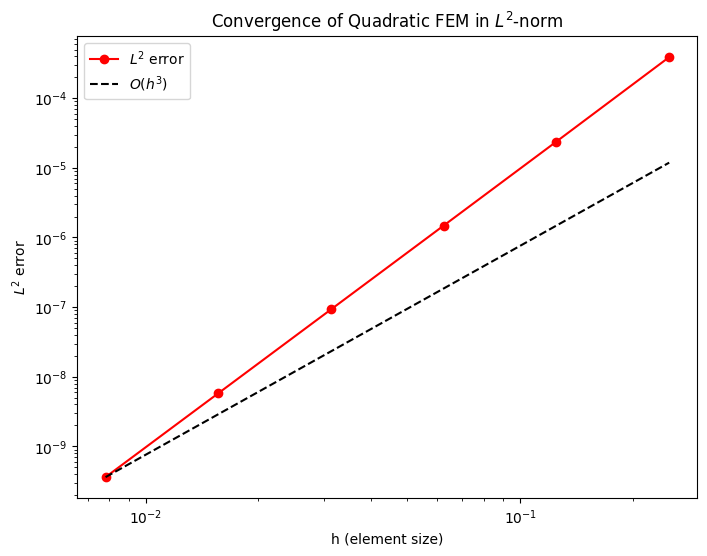

In [12]:
if __name__ == "__main__":
    main()

From a purely theoretical standpoint, for a $2^\text{nd}$-degree (quadratic) finite element method in 1D, we expect

$$
\|u - u_h\|_{L^2} \;\approx\; \mathcal{O}(h^{3}),
$$

provided $u$ is sufficiently smooth and we are in the “asymptotic” regime (i.e., $h$ is sufficiently small). However, it is **not unusual** to see an apparent slope **greater** than 3 in a plot like yours, especially when:

1. You have relatively few data points (so you may be in a *pre-asymptotic* regime),
2. You have chosen a problem $-\,u'' = \pi^2 \sin(\pi x)$ on a uniform mesh, which sometimes exhibits **superconvergence** in the $L^2$-norm for 1D Poisson problems,
3. You are combining high-order shape functions with exact (or high-order) quadrature, which can reinforce superconvergence effects.

In such cases, it is perfectly possible to observe slopes **above** 3 for a range of mesh sizes. If you refine further (say, up to $N=512, 1024, \ldots$), you may see the slope begin to settle closer to 3 — or it may remain around 4 due to a well-known superconvergence phenomenon in the $L^2$-norm for even-order finite elements in 1D.

### In Other Words
- **Yes**, your new plot makes sense.
- The fact that the red error curve sits above the dashed $O(h^3)$ line and exhibits a slope closer to 4 or 5 is not necessarily a bug.
- You are likely observing **superconvergence** (or at least pre-asymptotic behavior) in the $L^2$-norm for this problem, mesh, and choice of shape functions.
- As you push to finer and finer grids, you might eventually see the slope level off closer to 3, or remain near 4 if the conditions for superconvergence remain satisfied. Both behaviors are well-documented in classical FEM theory for 1D problems.
